In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

In [2]:

# Spark Session oluşturma
spark = SparkSession.builder.appName('project').getOrCreate()

# CSV dosyasını Spark DataFrame'e yükleme
data = spark.read.csv('train.csv', header=True, inferSchema=True)

# Veri setini gösterme
data.show()

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|        7|      1|           1|   0|          2|
|          563|   1|        0.5|       1|  2|     1|        41|  0.9|      145|      5|  6|     1263|    1716|2603|  11|   2|     

In [3]:


def DataInfo(dataframe, head=5):
    # Dataframe'in ilk kısmını gösterme
    print("################## Dataframe Head ##################")
    dataframe.show(head)
    
    # Dataframe'in yapısal bilgilerini gösterme
    print("################## Dataframe Schema ##################")
    dataframe.printSchema()
    
    # Dataframe'in istatistiksel özetini gösterme
    print("################## Dataframe Summary ##################")
    dataframe.describe().show()
    
    # Dataframe'in sütunlarını gösterme
    print("################## Dataframe Columns ##################")
    print(dataframe.columns)
    
    # Dataframe'in satır ve sütun sayısını gösterme
    print("################## Dataframe Shape ##################")
    print((dataframe.count(), len(dataframe.columns)))
    
    # Eksik değer sayısını gösterme
    print("################## Isnull sum() ##################")
    for col in dataframe.columns:
        print(col, ":", dataframe.filter(dataframe[col].isNull()).count())

# Fonksiyonu çağırma
DataInfo(data)

################## Dataframe Head ##################
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|        7|      1|           1|   0|          2|
|          563|   1|        0.5|       1|  2|     1|        41|  0.9|      14

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Kategorik sütunları toplama
    cat_cols = [col for col in dataframe.columns if dataframe.select(col).distinct().count() < cat_th]
    
    # Sayısal ancak kategorik sütunları toplama
    num_but_cat = [col for col in dataframe.columns if (dataframe.select(col).distinct().count() < cat_th) and (dataframe.select(col).dtypes != 'string')]
    
    # Kategorik ancak sayısal sütunları toplama
    cat_but_car = [col for col in dataframe.columns if (dataframe.select(col).distinct().count() > car_th) and (dataframe.select(col).dtypes == 'string')]
    
    # Kategorik sütunları birleştirme
    cat_cols = list(set(num_but_cat + cat_cols))
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # Sayısal sütunları toplama
    num_cols = [col for col in dataframe.columns if col not in cat_cols and col not in cat_but_car]
    
    print(f"Observations: {dataframe.count()}")
    print(f"Variables: {len(dataframe.columns)}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols,num_cols,cat_but_car =grab_col_names(data)

Observations: 2000
Variables: 21
cat_cols: 8
num_cols: 13
cat_but_car: 0
num_but_cat: 8


In [5]:
cat_cols

['dual_sim',
 'three_g',
 'touch_screen',
 'wifi',
 'four_g',
 'blue',
 'price_range',
 'n_cores']

In [6]:
num_cols

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [7]:
#kategorik değişken analizi
def cat_summary(dataframe, col_name):
    # Sütun için değer sayılarını ve oranlarını hesaplama
    col_counts = dataframe.groupBy(col_name).count()
    
    # Verileri gösterme
    col_counts.show()

for col in cat_cols:
    cat_summary(data,col)
    

+--------+-----+
|dual_sim|count|
+--------+-----+
|       1| 1019|
|       0|  981|
+--------+-----+

+-------+-----+
|three_g|count|
+-------+-----+
|      1| 1523|
|      0|  477|
+-------+-----+

+------------+-----+
|touch_screen|count|
+------------+-----+
|           1| 1006|
|           0|  994|
+------------+-----+

+----+-----+
|wifi|count|
+----+-----+
|   1| 1014|
|   0|  986|
+----+-----+

+------+-----+
|four_g|count|
+------+-----+
|     1| 1043|
|     0|  957|
+------+-----+

+----+-----+
|blue|count|
+----+-----+
|   1|  990|
|   0| 1010|
+----+-----+

+-----------+-----+
|price_range|count|
+-----------+-----+
|          1|  500|
|          3|  500|
|          2|  500|
|          0|  500|
+-----------+-----+

+-------+-----+
|n_cores|count|
+-------+-----+
|      1|  242|
|      6|  230|
|      3|  246|
|      5|  246|
|      4|  274|
|      8|  256|
|      7|  259|
|      2|  247|
+-------+-----+



+-------+-----------------+
|summary|    battery_power|
+-------+-----------------+
|  count|             2000|
|   mean|        1238.5185|
| stddev|439.4182060835313|
|    min|              501|
|    max|             1998|
+-------+-----------------+



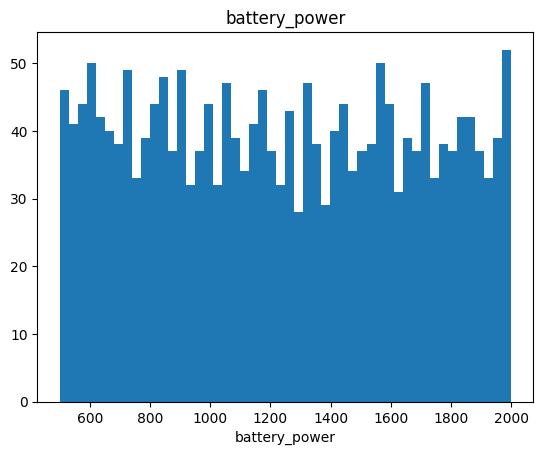

#####################################
+-------+------------------+
|summary|       clock_speed|
+-------+------------------+
|  count|              2000|
|   mean|1.5222499999999983|
| stddev| 0.816004208895068|
|    min|               0.5|
|    max|               3.0|
+-------+------------------+



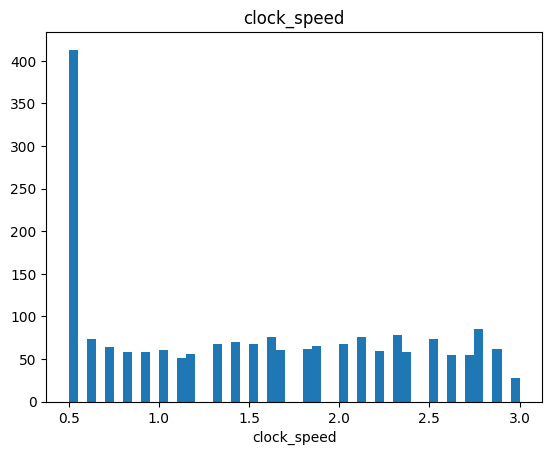

#####################################
+-------+-----------------+
|summary|               fc|
+-------+-----------------+
|  count|             2000|
|   mean|           4.3095|
| stddev|4.341443747983898|
|    min|                0|
|    max|               19|
+-------+-----------------+



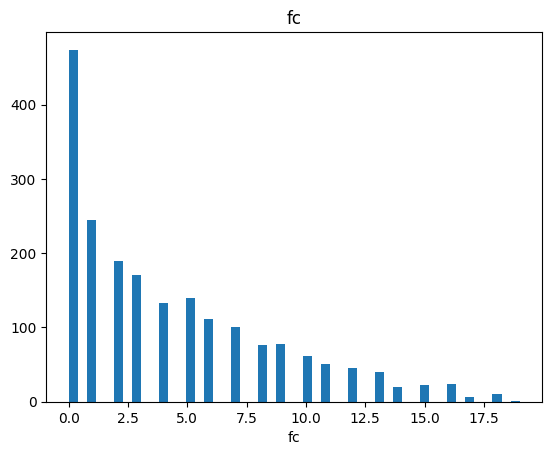

#####################################
+-------+------------------+
|summary|        int_memory|
+-------+------------------+
|  count|              2000|
|   mean|           32.0465|
| stddev|18.145714955206856|
|    min|                 2|
|    max|                64|
+-------+------------------+



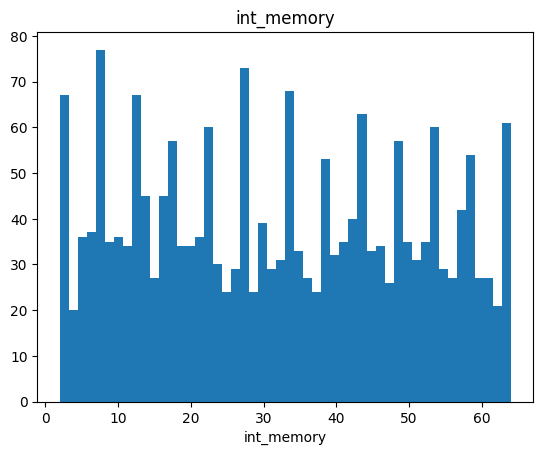

#####################################
+-------+------------------+
|summary|             m_dep|
+-------+------------------+
|  count|              2000|
|   mean|0.5017500000000017|
| stddev|0.2884155496235117|
|    min|               0.1|
|    max|               1.0|
+-------+------------------+



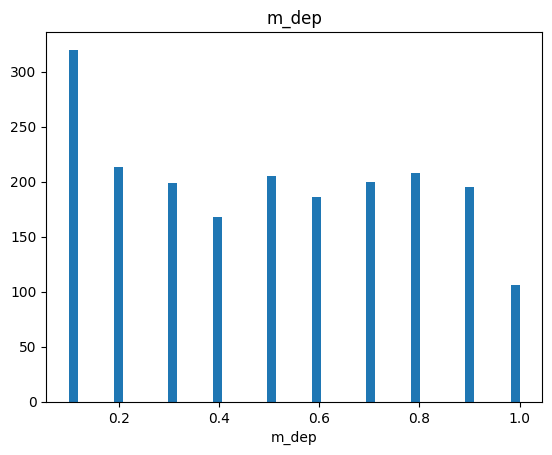

#####################################
+-------+-----------------+
|summary|        mobile_wt|
+-------+-----------------+
|  count|             2000|
|   mean|          140.249|
| stddev|35.39965489638834|
|    min|               80|
|    max|              200|
+-------+-----------------+



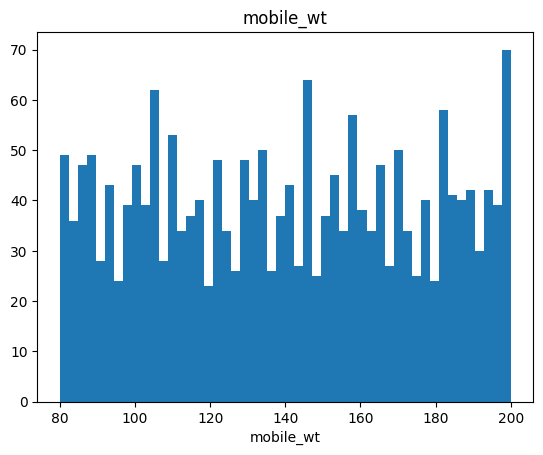

#####################################
+-------+-----------------+
|summary|               pc|
+-------+-----------------+
|  count|             2000|
|   mean|           9.9165|
| stddev|6.064314941347778|
|    min|                0|
|    max|               20|
+-------+-----------------+



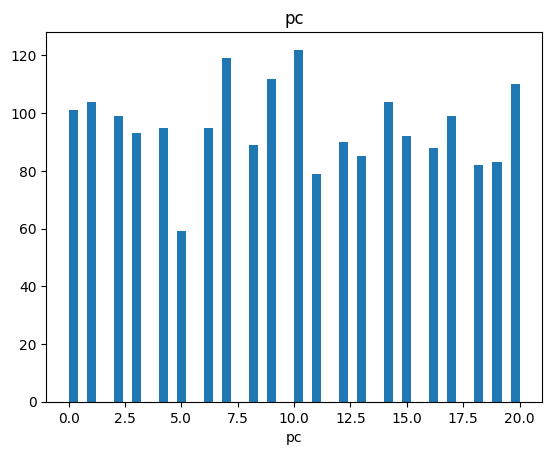

#####################################
+-------+------------------+
|summary|         px_height|
+-------+------------------+
|  count|              2000|
|   mean|           645.108|
| stddev|443.78081080643824|
|    min|                 0|
|    max|              1960|
+-------+------------------+



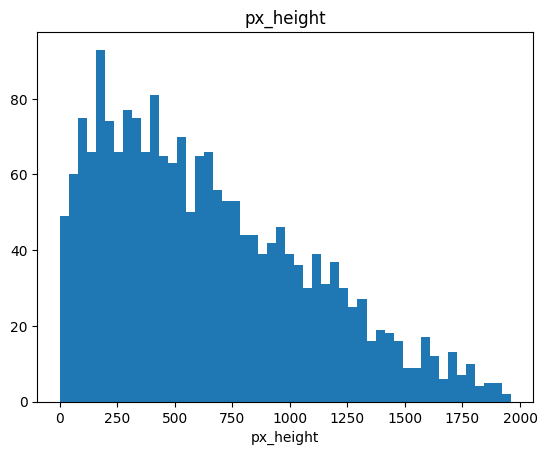

#####################################
+-------+-----------------+
|summary|         px_width|
+-------+-----------------+
|  count|             2000|
|   mean|        1251.5155|
| stddev|432.1994469463379|
|    min|              500|
|    max|             1998|
+-------+-----------------+



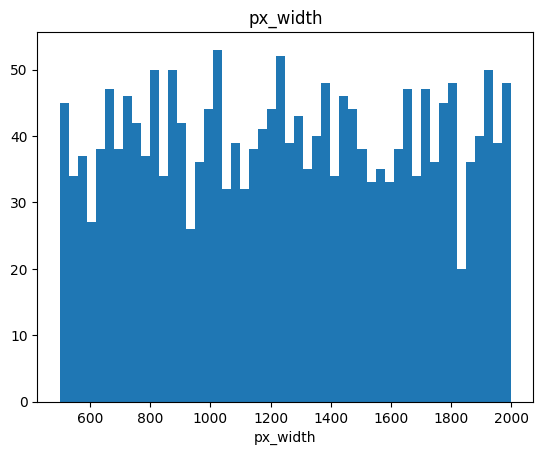

#####################################
+-------+------------------+
|summary|               ram|
+-------+------------------+
|  count|              2000|
|   mean|          2124.213|
| stddev|1084.7320436099492|
|    min|               256|
|    max|              3998|
+-------+------------------+



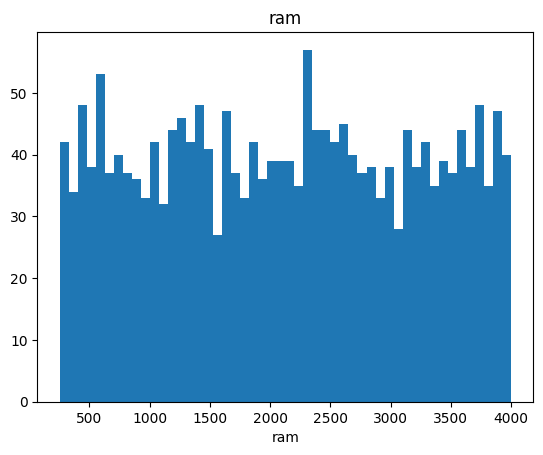

#####################################
+-------+-----------------+
|summary|             sc_h|
+-------+-----------------+
|  count|             2000|
|   mean|          12.3065|
| stddev|4.213245004356303|
|    min|                5|
|    max|               19|
+-------+-----------------+



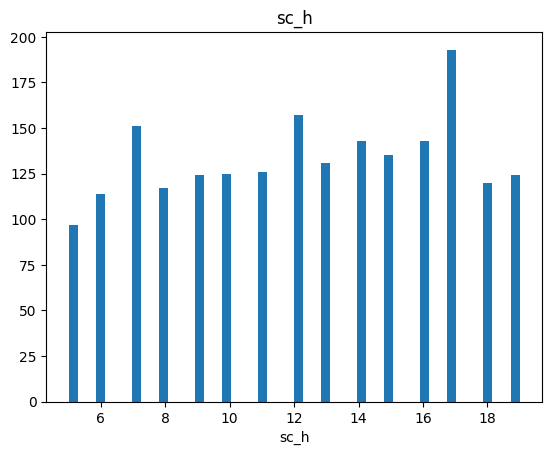

#####################################
+-------+-----------------+
|summary|             sc_w|
+-------+-----------------+
|  count|             2000|
|   mean|            5.767|
| stddev|4.356397605826408|
|    min|                0|
|    max|               18|
+-------+-----------------+



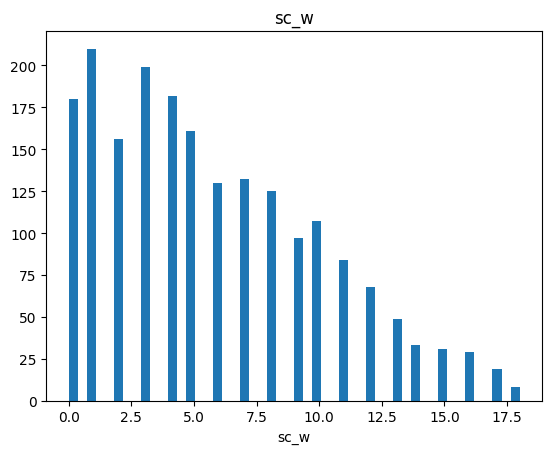

#####################################
+-------+-----------------+
|summary|        talk_time|
+-------+-----------------+
|  count|             2000|
|   mean|           11.011|
| stddev|5.463955197766688|
|    min|                2|
|    max|               20|
+-------+-----------------+



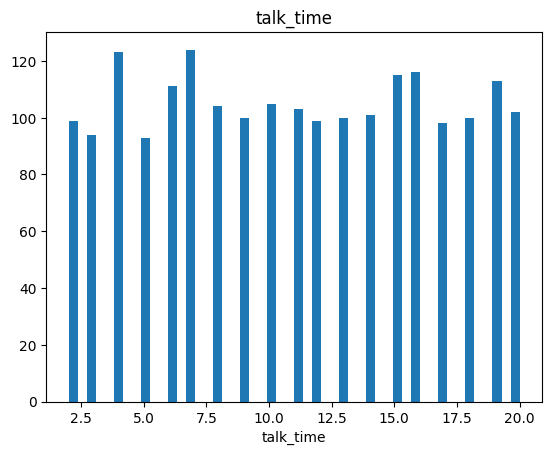

#####################################


In [8]:
#numeric değişken analizi

def num_summary(dataframe, col):
    summary = dataframe.select(col).describe()
    summary.show()
    
    pandas_df = dataframe.select(col).toPandas()
    plt.hist(pandas_df[col], bins=50)
    plt.xlabel(col)
    plt.title(col)
    plt.show()
    
    print("#####################################")

for col in num_cols:
    num_summary(data,col)

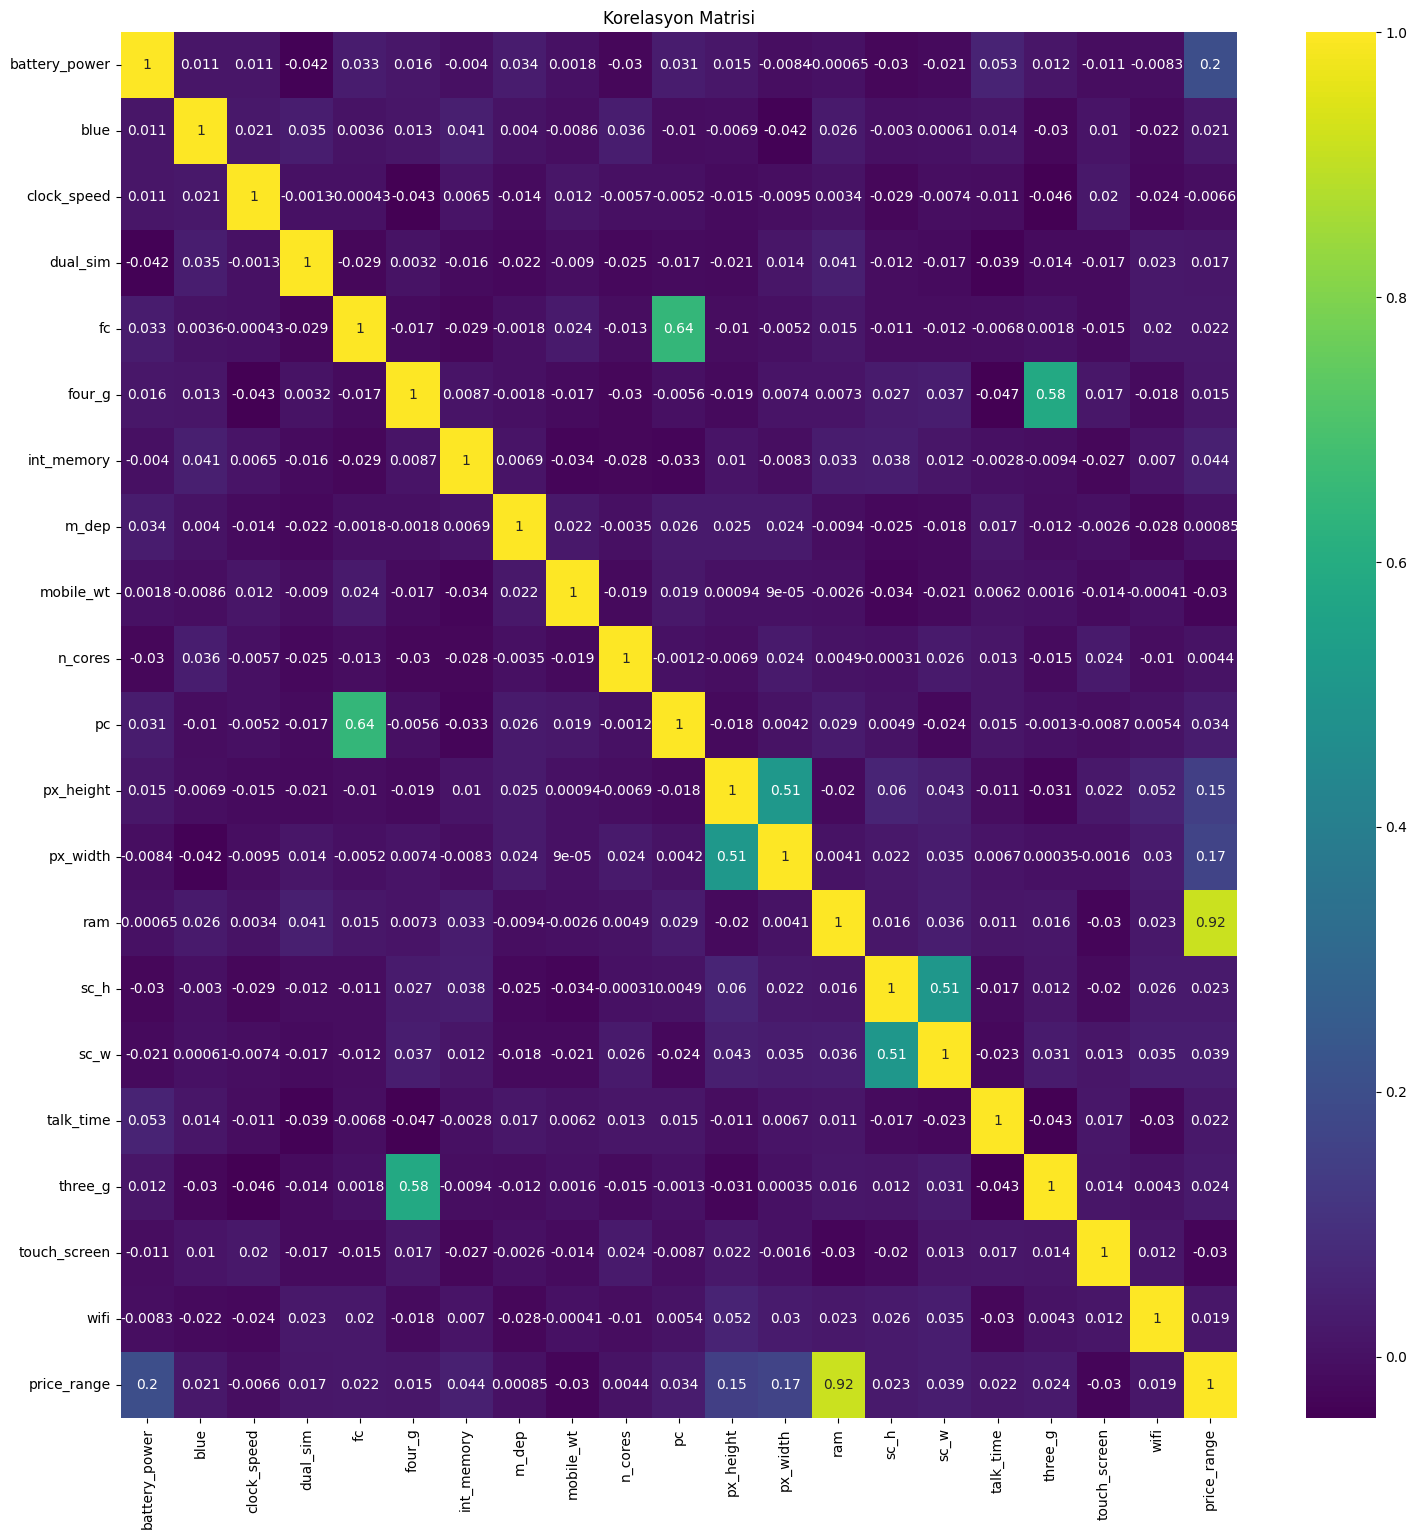

In [24]:
import seaborn as sns
corr_df = data.toPandas()
corr_matrix = corr_df.corr()

# Matrisi Seaborn ile görselleştir
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Korelasyon Matrisi")
plt.show()

In [25]:
#aykiri deger analizi
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [26]:
pandas_df = data.toPandas()
for col in num_cols:
    print(col, check_outlier(pandas_df, col))

battery_power False
clock_speed False
fc False
int_memory False
m_dep False
mobile_wt False
pc False
px_height False
px_width False
ram False
sc_h False
sc_w False
talk_time False


In [27]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [41]:
#vectore cevir
vec = VectorAssembler(inputCols=['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'four_g',
 'wifi',
 'three_g',
 'blue',
 'n_cores',
 'touch_screen',
 'dual_sim'],outputCol="features")

In [42]:
train_data, test_data = data.randomSplit([0.7, 0.3], seed=12345)

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier,LogisticRegression

In [39]:
evaluator = MulticlassClassificationEvaluator(labelCol="price_range", metricName="accuracy")

rf = RandomForestClassifier(labelCol="price_range", featuresCol="features")
lr = LogisticRegression(labelCol="price_range", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="price_range", featuresCol="features")
pipeline_rf = Pipeline(stages=[vec, rf])
pipeline_lr = Pipeline(stages=[vec, lr])
pipeline_dt = Pipeline(stages=[vec, dt])

pipelines = [
    ('RF', pipeline_rf),
    ('LR', pipeline_lr),
    ('DT', pipeline_dt)
]

paramGrid_empty = ParamGridBuilder().build()

for name, pipeline in pipelines:
    crossval_model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid_empty,
        evaluator=evaluator,
        numFolds=5
    )
    baseModel = crossval_model.fit(train_data)
    best_model = baseModel.bestModel
    predictions = best_model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    print(f"{name} Doğruluk:", accuracy)



RF Doğruluk: 0.8266666666666667
LR Doğruluk: 0.965
DT Doğruluk: 0.8133333333333334


In [45]:
lr = LogisticRegression(labelCol="price_range", featuresCol="features")

pipeline_lr = Pipeline(stages=[vec, lr])
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])  
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) 
             .addGrid(lr.maxIter, [10, 20, 50]) 
             .build())
             
evaluator = MulticlassClassificationEvaluator(labelCol="price_range", metricName="accuracy")
crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid, 
                             evaluator=evaluator,
                             numFolds=5)

base_model = crossval_lr.fit(train_data)


best_model_lr = base_model.bestModel
predictions = best_model_lr.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print(f"Doğruluk:", accuracy)

Doğruluk: 0.9466666666666667


In [17]:
#modeli kaydet
best_model_lr.save("models/logisticRegressionModel")

In [20]:
test_data_without_features = test_data.select([col for col in test_data.columns if col != "features"])
test_data_without_features.show()

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          503|   1|        1.8|       1|  1|     1|        13|  0.7|      131|      1|  4|     1495|    1688|3117|  19|   6|        9|      1|           0|   1|          3|
|          507|   1|        0.5|       1|  1|     0|        32|  0.5|      141|      7| 11|      936|    1398|1702|  17|   0|        5|      1|           1|   1|          1|
|          508|   1|        1.3|       0|  1|     0|        50|  0.7|       82|      5|  9|      102|    1195|2175|  14|   4|     

In [23]:
#test.csv olustur
pandas_df_test = test_data_without_features.toPandas()
pandas_df_test.to_csv('test.csv',index=False)

In [24]:
#spark oturumu sonlandir
spark.stop()